In [2]:
# HRS 2020 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from functools import reduce
from scipy.stats import ttest_ind
from scipy.interpolate import UnivariateSpline

#setting basic styles and formatting for plots
%matplotlib inline 
plt.style.use("seaborn")

In [3]:
hrs20_lb = pd.read_sas('h20lb_r.sas7bdat')
hrs20_n = pd.read_sas('h20n_r.sas7bdat')
hrs20_prr = pd.read_sas('h20pr_r.sas7bdat')

In [4]:
hrs_nadrop = ['NX067_R', 'NLB020A', 'NLB020B', 'NLB020C', 'NN147', 'NN099']

hrs_relevant = ['HHID', 'PN', 'NX067_R', 'ages', 'NLB020A', 'NLB020B', 'NLB020C', 'lonely_yn', 'lonely_score',
                            'NN099', 'NN100', 'NN101', 'NN147', 'NN207']


#determine if lonely; respondent is lonely when 'NLB020A', 'NLB020B', or 'NLB020C' has value as < 3 (rationale above)
def det_lonely(df):
    lonely_yn_df = df.copy()
    lonely_yn_df['lonely_yn'] = False

    lonely_yn_df['lonely_yn'] = lonely_yn_df[(lonely_yn_df['NLB020A'] < 3) | (lonely_yn_df['NLB020B'] < 3) | 
                                          (lonely_yn_df['NLB020C'] < 3)]['lonely_yn'].map({False: True})
    lonely_yn_df['lonely_yn'] = lonely_yn_df['lonely_yn'].fillna(False)
    
    return lonely_yn_df


#data read in from HRS has non-integer identification numbers (HHID and PN); this function standardizes them as integers
def clean_id(df):
    cleaned_df =  df.copy()
    #using string slicing to clean HHID and PN identification numbers as clean integers
    cleaned_df[['HHID', 'PN']] = cleaned_df[['HHID', 'PN']].astype(str).applymap(lambda x: x[2:-1]).astype(int)
    return cleaned_df


#data from HRS only provides year of birth; this function uses survey year and birth year to calculate age in new column 'ages'
def det_age(df, year):
    aged_df = df.copy()
    aged_df['ages'] = aged_df['NX067_R']
    aged_df.ages = aged_df.loc[:, 'ages'].apply(lambda x: x * -1 + year)
    return aged_df

#scoring loneliness: reverse scored such that max score (most lonely) = 9; min score (least lonely) = 3 (UCLA 3 Item)
def score_loneliness(df):
    scored_df = df.copy()
    scored_df['lonely_score'] = scored_df.apply(lambda x: 12 - (x['NLB020A'] + x['NLB020B'] + x['NLB020C']), axis=1)
    return scored_df


def merge_hrs(df1, df2, df3, int_year):
    merged_df = reduce(lambda  left,right: pd.merge(left,right, on=['HHID', 'PN'], how='outer'), [df1, df2, df3])
    
    #dropping participants with ANY blank values within the necessary fields
    merged_df_drop = merged_df.dropna(axis='index', how='any', subset=hrs_nadrop)
    
    #determine if 'lonely' according to definition, add to new column
    merged_lonely_yn = det_lonely(merged_df_drop) 
    
    #clean HHID and PN
    merged_cid = clean_id(merged_lonely_yn)
    
    #determine age from birth year and year of interview, add to new column
    merged_aged = det_age(merged_cid, int_year)
    
    #set NaN values in N100 (number of nights spent in hospital) to zero; HRS data codebook implies NaN values mean 0 nights
    merged_aged['NN100'] = merged_aged['NN100'].fillna(0)
    
        
    #determine reverse-scored loneliness score, add to new column
    merged_scored = score_loneliness(merged_aged)
    
    #get only relevent columns in final merged df
    merged_final = merged_scored[hrs_relevant]

    return merged_final

In [5]:
#defining function that will take df and a dictionary to rename columns in the dataframe
def rename_col(df, dictionary):
    renamed_df = df.copy()
    renamed_df.rename(dictionary, axis=1, inplace=True)
    return renamed_df

#creating python dictionaries to connect relevant columns to the corresponding HRS 2012 columns
hrs20_lb_rename = {'RLB019A':'NLB020A', 'RLB019B':'NLB020B', 'RLB019C':'NLB020C'}
hrs20_n_rename = {'RN099':'NN099', 'RN100':'NN100', 'RN101':'NN101', 'RN147':'NN147', 'RN207':'NN207'}
hrs20_prr_rename = {'RX067_R':'NX067_R'}

hrs20_lbr = rename_col(hrs20_lb, hrs20_lb_rename)
hrs20_nr = rename_col(hrs20_n, hrs20_n_rename)
hrs20_prrr = rename_col(hrs20_prr, hrs20_prr_rename)

In [29]:
hrs20m = merge_hrs(hrs20_lbr, hrs20_nr, hrs20_prrr, 2020)
hrs20m.describe()

,HHID,PN,NX067_R,ages,NLB020A,NLB020B,NLB020C,lonely_score,NN099,NN100,NN101,NN147,NN207
count,4537.000000,4537.000000,4537.000000,4537.000000,4537.000000,4537.000000,4537.000000,4537.000000,4537.000000,4537.000000,956.000000,4537.000000,4537.000000
mean,389081.873705,15.079348,1950.694291,69.305709,2.446330,2.523033,2.502976,4.527661,4.163765,1.456249,24.628661,141.419440,450.329072
std,279061.327433,7.313095,10.424595,10.424595,0.697561,0.619325,0.647579,1.658630,1.640894,33.118446,132.113093,337.852852,1318.689323
min,10075.000000,10.000000,1919.000000,31.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,82405.000000,10.000000,1942.000000,61.000000,2.000000,2.000000,2.000000,3.000000,5.000000,0.000000,2.000000,3.000000,0.000000
50%,501838.000000,10.000000,1952.000000,68.000000,3.000000,3.000000,3.000000,4.000000,5.000000,0.000000,4.000000,6.000000,0.000000
75%,541029.000000,20.000000,1959.000000,78.000000,3.000000,3.000000,3.000000,6.000000,5.000000,0.000000,7.000000,15.000000,300.000000
max,959738.000000,43.000000,1989.000000,101.000000,3.000000,3.000000,3.000000,9.000000,8.000000,998.000000,999.000000,999.000000,20000.000000


In [9]:
#applying smoothing spline to data using UnivariateSpline function in SciPy
def apply_spline(df, lower_lim, upper_lim): 
    dfc = df.copy()
    #chose upper and lower limit depending survey year and data available
    dfc_c = dfc[(dfc['ages'] >= lower_lim) & (dfc['ages'] <= upper_lim)]

    dfc_scores = dfc_c.groupby('ages').lonely_score.mean()
    dfc_ages = dfc_scores.index
    spl = UnivariateSpline(dfc_ages, dfc_scores)
    return [dfc_ages, dfc_scores, spl]

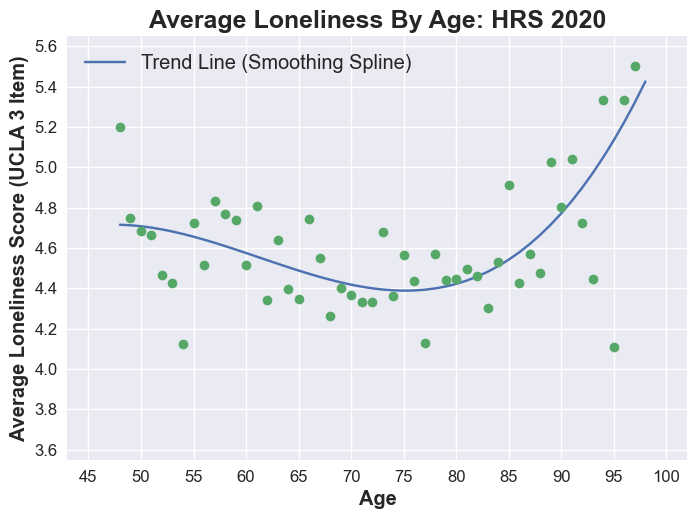

In [34]:
#using apply_spline() to get spline data to plot; chose upper and lower limit based on data available
hrs20_splined = apply_spline(hrs20m, 48, 98)
hrs20_rawx = hrs20_splined[0]
hrs20_rawy = hrs20_splined[1]
hrs20_spline = hrs20_splined[2]

#rendering plot with regression line and actual points
plt.title("Average Loneliness By Age: HRS 2020", fontsize=18, fontweight='bold')
plt.plot(hrs20_rawx, hrs20_spline(hrs20_rawx), label='Trend Line (Smoothing Spline)')
plt.plot(hrs20_rawx, hrs20_rawy, 'o')

plt.xlabel('Age', fontsize='x-large', fontweight='bold')
plt.ylabel('Average Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=np.arange(45, 110, 5),  fontsize='large')
#plt.yticks(ticks=np.arange(3.6, 5.6, .2),  fontsize='large')
#plt.xlim(43, 98)
#plt.ylim(3.55, 5.5)

plt.yticks(ticks=np.arange(3.6, 5.8, .2),  fontsize='large')
plt.xlim(43, 102)
plt.ylim(3.55, 5.65)

plt.legend(fontsize='x-large', loc='upper left')
plt.tight_layout
plt.show()

In [22]:
#when using this function, input column argument within single quotations; ex: hrs_visits(hrs12mc, 'NN147', 998, 999)
def hrs_visits(df, column, DK_val, RF_val):
    dfc = df.copy()
    
    #numeric DK_val and RF_val indicate "Don't Know" and "Refused [to answer]" respectively in the data; drop those values
    dfc_clean = dfc[(dfc[column] != DK_val) & (dfc[column] != RF_val)]
    
    #setting values such that values over 99th percentile are replaced with the 99th percentile value
    #this is done in order to control for the disproportionately large outliers within the raw data (ex: '900' physician visits)
    dfc_clean.loc[dfc_clean[column] >= dfc_clean[column].quantile(.99), column] = dfc_clean[column].quantile(.99)
    
    #run a t-test to determine whether the differences between the means of the data are significantly different
    lonely_y = dfc_clean[dfc_clean.lonely_yn == True][column]
    lonely_n = dfc_clean[dfc_clean.lonely_yn == False][column]
    ttest = ttest_ind(lonely_y, lonely_n)

    #return descriptive statistics about the loneliness (count, mean, standard deviation, quarentiles, etc) to be used in plots
    #also return t-test output which includes the t-statistic and p-value (to determine statistical significance)
    lonely_y_describe = lonely_y.describe()
    lonely_n_describe = lonely_n.describe()
    return [lonely_y_describe, lonely_n_describe, ttest]

In [27]:
hrs20_dvisits = hrs_visits(hrs20m, 'NN147', 998, 999)
hrs20_dvisits

[count    2310.000000
 mean        8.506926
 std         9.723759
 min         0.000000
 25%         2.000000
 50%         6.000000
 75%        10.000000
 max        55.000000
 Name: NN147, dtype: float64,
 count    1617.000000
 mean        7.118120
 std         8.674477
 min         0.000000
 25%         2.000000
 50%         4.000000
 75%        10.000000
 max        55.000000
 Name: NN147, dtype: float64,
 Ttest_indResult(statistic=4.602620073185872, pvalue=4.303994995494895e-06)]

<BarContainer object of 2 artists>

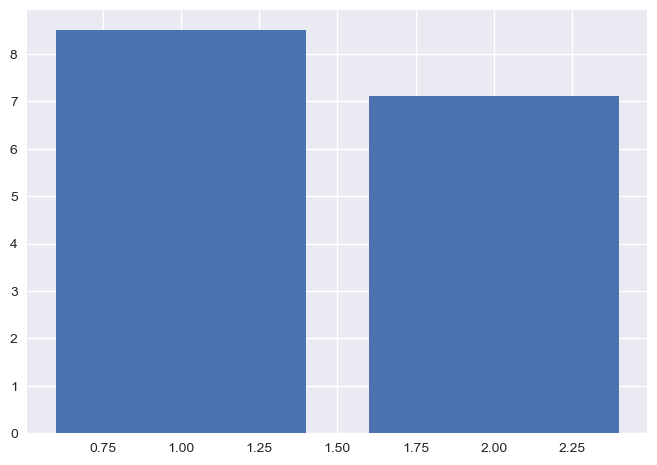

In [26]:
plt.bar([1, 2], [hrs20_dvisits[0]["mean"], hrs20_dvisits[1]["mean"]])